### Start to look at cosine similarity of decoder weights, getting at: 
https://www.notion.so/walkerlab/Potential-Decoder-weights-analyses-1b22dc9f99928041aad6d0e0e79be875

Items: 
- build code to get decoder weights, todo: rely on np array or df?
- check the anticorrelation of binary decoder weights, is this true?
- look at cross time similarity
- look at cross condition similarity


In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.single_selected_feature_configs import *
import scipy
import argparse
import copy

### Are two weights anti-correlated?
Across all timebins, splits, seems like decoder weights between the two options (chosen vs not) are not completely anti-correlated

In [2]:
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"

res = io_utils.read_selected_features_models(args, FEATURES, "chosen")

In [3]:
res["weights"] = res.apply(lambda x: x.models.coef_, axis=1)
res["cosine_sim"] = res["weights"].apply(lambda x: classifier_utils.cosine_sim(x[0, :], x[1, :]))

<Axes: >

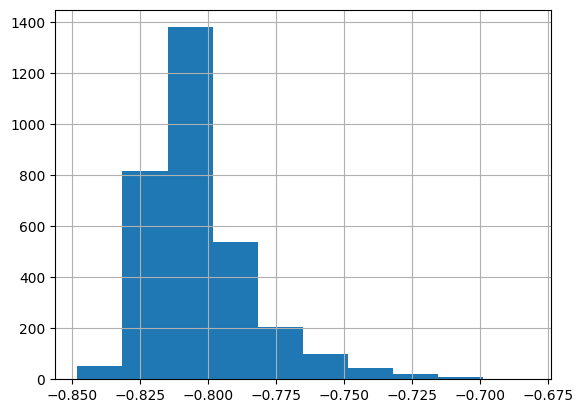

In [5]:
res["cosine_sim"].hist()

### Plot cosine sims by time
- Looks like a more stable feature representation during decision time, feedback, when feature is preferred
- although, in general, higher than 0 cosine sim for all points in pref, maybe suggesting time correlation effect

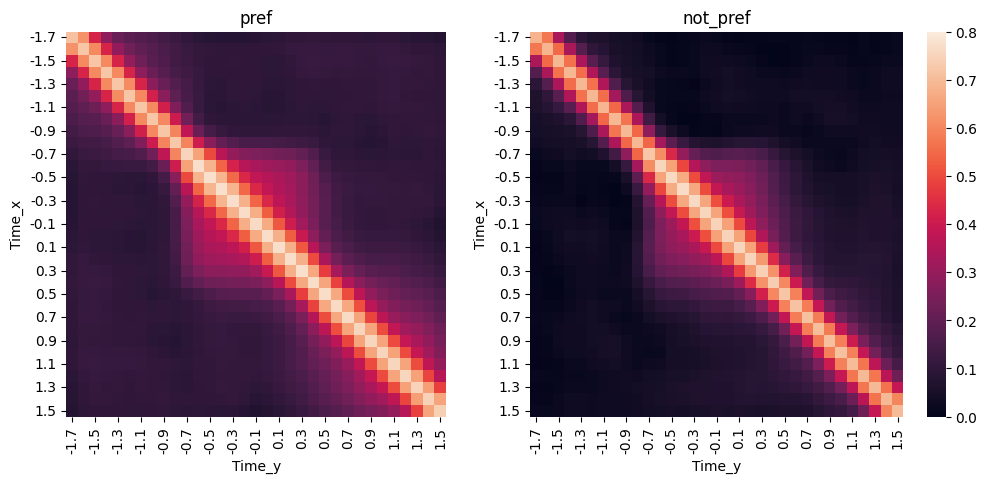

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[5.7, 7])
for i, cond in enumerate(["pref", "not_pref"]):
    args = argparse.Namespace(
        **SingleSelectedFeatureConfigs()._asdict()
    )
    args.trial_event = "FeedbackOnsetLong"

    models = io_utils.read_selected_features_models(args, FEATURES, cond)
    weights = io_utils.get_selected_features_weights(models)
    cosine_sims = classifier_utils.get_cross_time_cosine_sim_of_weights(weights)
    sns.heatmap(cosine_sims, ax=axs[i], cbar=(i == 1), vmin=0, vmax=0.8)
    axs[i].set_title(cond)


### Replot above but this time both have the their own colorbars

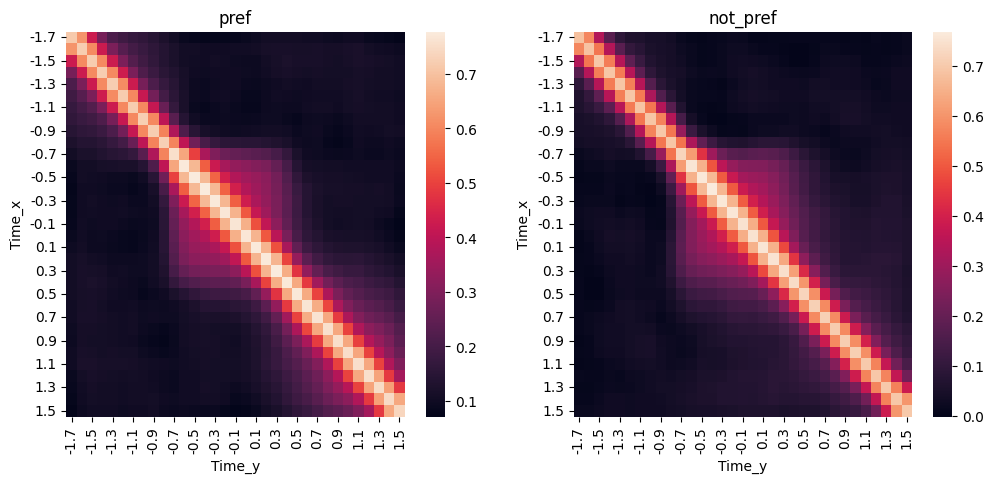

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for i, cond in enumerate(["pref", "not_pref"]):
    args = argparse.Namespace(
        **SingleSelectedFeatureConfigs()._asdict()
    )
    args.trial_event = "FeedbackOnsetLong"

    models = io_utils.read_selected_features_models(args, FEATURES, cond)
    weights = io_utils.get_selected_features_weights(models)
    cosine_sims = classifier_utils.get_cross_time_cosine_sim_of_weights(weights)
    sns.heatmap(cosine_sims, ax=axs[i])
    axs[i].set_title(cond)

### Plot cosine sims across conditions
Load the weights separately by conditions, 

In [4]:
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"

pref_models = io_utils.read_selected_features_models(args, FEATURES, "pref")
pref_weights = io_utils.get_selected_features_weights(pref_models)

n_pref_models = io_utils.read_selected_features_models(args, FEATURES, "not_pref")
n_pref_weights = io_utils.get_selected_features_weights(n_pref_models)


In [8]:
# get accuracies to overlay
args = argparse.Namespace(
    **SingleSelectedFeatureConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"

accs = io_utils.read_selected_features(args, FEATURES)

Text(0.5, 1.0, '')

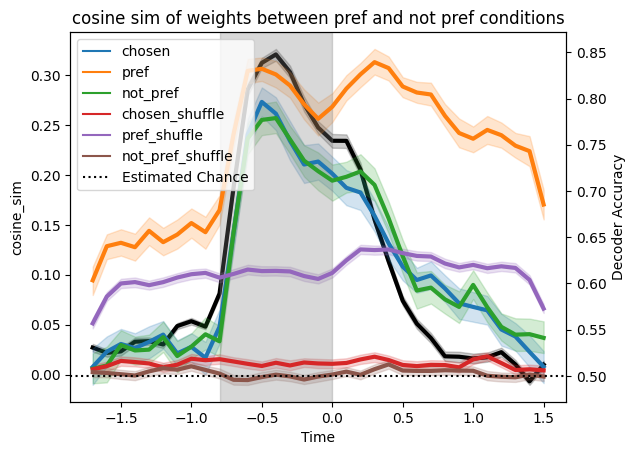

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

res = classifier_utils.get_cross_cond_cosine_sim_of_weights(pref_weights, n_pref_weights)
sns.lineplot(res, x="Time", y="cosine_sim", color="black", linewidth=3, ax=ax1)

visualization_utils.visualize_preferred_beliefs(args, accs, ax2)


ax1.set_title("cosine sim of weights between pref and not pref conditions")
ax2.set_title("")


<Axes: xlabel='Time', ylabel='cosine_sim'>

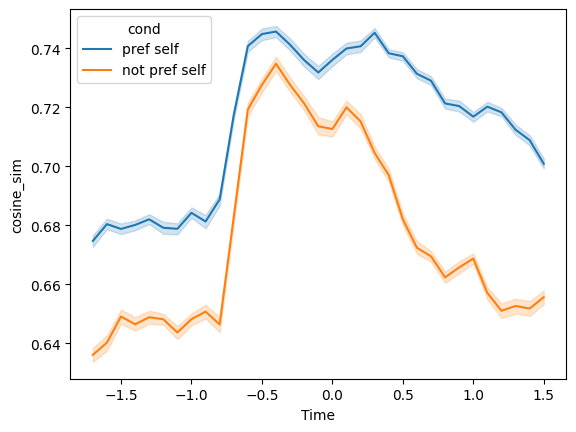

In [6]:
fig, ax = plt.subplots()

all_res = []

res = classifier_utils.get_cross_cond_cosine_sim_of_weights(pref_weights, pref_weights, exclude_same_run=True)
res["cond"] = "pref self"
all_res.append(res)

res = classifier_utils.get_cross_cond_cosine_sim_of_weights(n_pref_weights, n_pref_weights, exclude_same_run=True)
res["cond"] = "not pref self"
all_res.append(res)

all_res = pd.concat(all_res)


sns.lineplot(all_res, x="Time", y="cosine_sim", hue="cond",ax=ax)